In [1]:
import numpy as np
from utils import load_object
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
num_seeds = 4
# path = '/home/taghianj/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'
path = '/home/mehran/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'

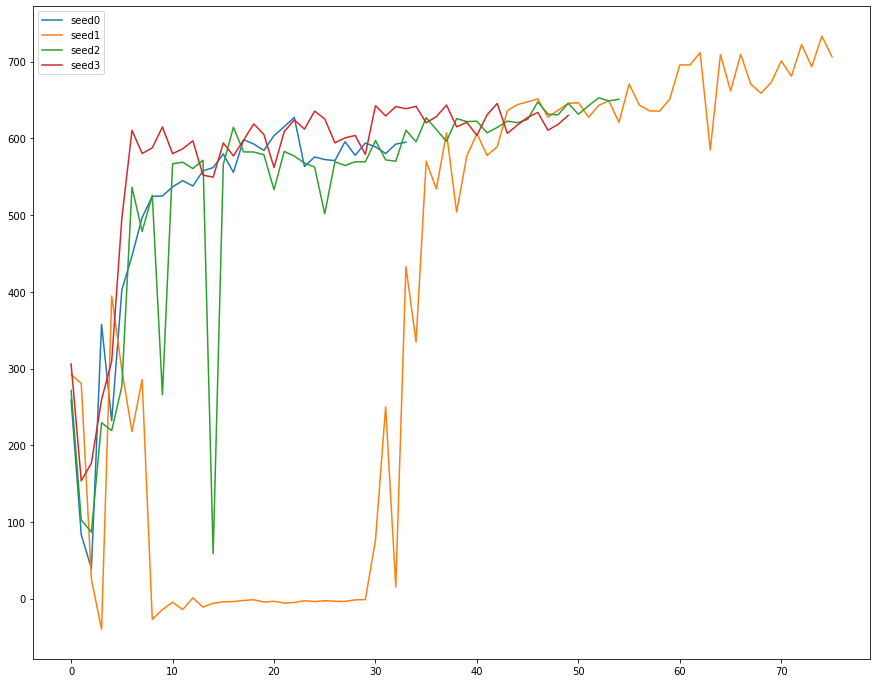

In [16]:
plt.figure(figsize=[15,12])
for s in range(num_seeds):
    data = load_object(f'{path}/seed{s}/eval.pkl')[:, 3]
    plt.plot(data, label=f'seed{s}')

plt.legend()

In [17]:
data = load_object("/home/me/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph/seed0/train.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/home/taghianj/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph/seed0/train.pkl'

In [10]:
data = pd.read_csv("/home/mehran/Documents/SAC_GCN/Data/Hopper-v2/thigh_joint/seed2/eval.csv")

In [11]:
data

,num_episodes,num_steps,num_updates,eval_reward
0,9.0,194.0,0.0,121.254049
1,19.0,432.0,175.0,109.890246
2,29.0,641.0,384.0,68.919956
3,39.0,898.0,641.0,46.692771
4,49.0,1130.0,873.0,45.844892
...,...,...,...,...
995,9959.0,1776840.0,1776583.0,721.098825
996,9969.0,1778792.0,1778535.0,691.768661
997,9979.0,1780701.0,1780444.0,718.182107
998,9989.0,1782675.0,1782418.0,681.614950
